In [1]:
import torch
from torch.nn import Module, Linear, ReLU
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adagrad

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42)

## Згенерував точки

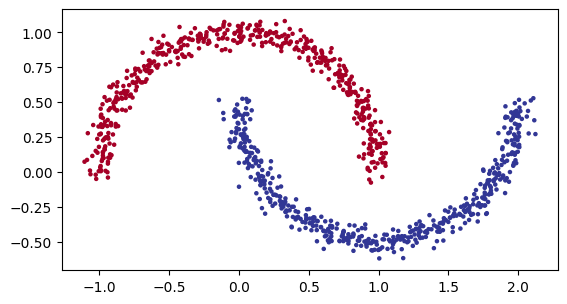

[[-0.02137124  0.40618608]
 [ 0.97670045 -0.45832306]
 [ 0.90405882 -0.37651952]
 ...
 [ 1.66258462 -0.3079193 ]
 [-0.94355873  0.3278936 ]
 [ 0.79419406  0.60777171]]


In [4]:
n_samples = 1000
noise = 0.05

X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
fig, ax = plt.subplots()
ax.scatter(x=X[:, 0], y=X[:, 1], c=y, s=5, cmap='RdYlBu')
ax.set_aspect('equal', 'box')
plt.show()
print(X)

## Перевів у тензори

In [5]:
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)
print(X.shape, y.shape)

torch.Size([1000, 2]) torch.Size([1000])


## Роблю поділ на train/test/validation

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

800 200 800 200


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(len(X_train), len(X_valid), len(y_train), len(y_valid))

640 160 640 160


In [8]:
print('Train:', len(X_train), len(y_train))
print('Valid:', len(X_valid), len(y_valid))
print('Test:', len(X_test), len(y_test))

Train: 640 640
Valid: 160 160
Test: 200 200


## Створює модель нейронної мережі, функцію втрат та оптимізатор

In [9]:
class MoonModel(Module):
    __input_neurons = 2
    __output_neurons = 1

    def __init__(self, layer2_neurons, layer3_neurons):
        super().__init__()
        self.layer2 = Linear(self.__input_neurons, layer2_neurons) 
        self.layer3 = Linear(layer2_neurons, layer3_neurons)
        self.layer_output = Linear(layer3_neurons, self.__output_neurons)
        self.activate = ReLU()
        
    def forward(self, x):
        result = self.activate(self.layer2(x))
        result = self.activate(self.layer3(result))
        result = self.layer_output(result)
        return result
        

In [10]:
model = MoonModel(layer2_neurons=10, layer3_neurons=10).to(device)
loss_fn = BCEWithLogitsLoss()
optimizer = torch.optim.Adagrad(params=model.parameters(), lr=0.05)

In [11]:
def accuracy(y_pred, y_true):
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")
    right_count = torch.eq(y_true, y_pred).sum().item()
    return right_count / len(y_true) * 100.0

## Навчаю модель

In [12]:
epochs = 1000

In [13]:
for epoch in range(epochs):
    #Перевів модель у трейн
    model.train()
    
    #запуск forward(перевизначения в __call__ Moduls)
    y_train_logits = model(X_train).squeeze()
    y_train_pred = torch.round(torch.sigmoid(y_train_logits))
    
    #рахую лог функцію втрат
    train_loss = loss_fn(y_train_logits, y_train)
    train_accuracy = accuracy(y_train_pred, y_train)
    
    #обнуляю старі градієнти
    optimizer.zero_grad()
    
    #запускаю backpropagation
    train_loss.backward()
    
    #застосовую оптимізатор
    optimizer.step()
    
    #перевірка теста під час навчання
    #переводжу в режим оцінки(валідую), дропаут, батчі викл
    model.eval()
    #викл градієнти
    with torch.inference_mode():
        #forward на валід
        y_valid_logits = model(X_valid).squeeze()
        y_valid_pred = torch.round(torch.sigmoid(y_valid_logits))
        #рахую лог функцію втрат
        valid_loss = loss_fn(y_valid_logits, y_valid)
        valid_accuracy = accuracy(y_valid_pred, y_valid)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}")
        print(f"Train: BCE:{train_loss:.5f} | {train_accuracy:.2f}%")
        print(f"Valid: BCE:{valid_loss:.5f} | {valid_accuracy:.2f}%")

Epoch: 0
Train: BCE:0.69529 | 37.66%
Valid: BCE:0.65945 | 71.25%
Epoch: 100
Train: BCE:0.11056 | 95.78%
Valid: BCE:0.09125 | 95.62%
Epoch: 200
Train: BCE:0.03262 | 99.84%
Valid: BCE:0.02427 | 100.00%
Epoch: 300
Train: BCE:0.01531 | 100.00%
Valid: BCE:0.01096 | 100.00%
Epoch: 400
Train: BCE:0.00927 | 100.00%
Valid: BCE:0.00651 | 100.00%
Epoch: 500
Train: BCE:0.00637 | 100.00%
Valid: BCE:0.00438 | 100.00%
Epoch: 600
Train: BCE:0.00475 | 100.00%
Valid: BCE:0.00319 | 100.00%
Epoch: 700
Train: BCE:0.00372 | 100.00%
Valid: BCE:0.00246 | 100.00%
Epoch: 800
Train: BCE:0.00302 | 100.00%
Valid: BCE:0.00198 | 100.00%
Epoch: 900
Train: BCE:0.00252 | 100.00%
Valid: BCE:0.00163 | 100.00%


# Візуалізація результатів

In [14]:
from helper_functions import plot_predictions, plot_decision_boundary

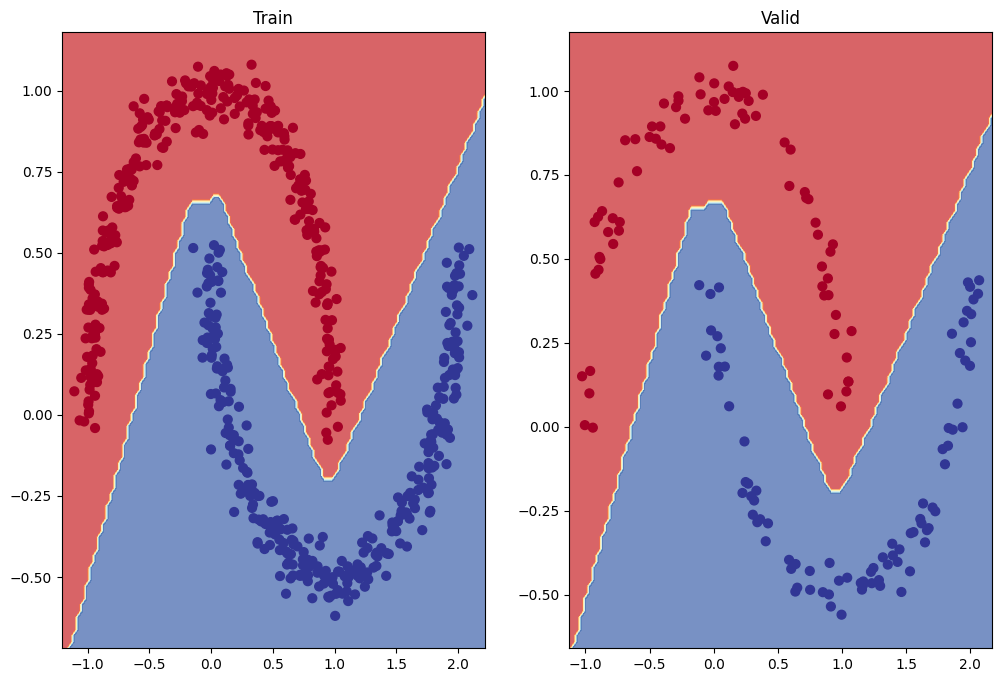

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Valid")
plot_decision_boundary(model, X_valid, y_valid)